In [1]:
import io
import requests
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F

In [2]:
# load the labels of the Imagnenet dataset
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'

# Input image list
def get_img_path(example_index):
    example_list = (('./input_images/0_RaceCar.jpg'),
                    ('./input_images/1_bicycle.jpg'),
                    ('./input_images/2_dog.jpg'),
                    ('./input_images/3_laptop.jpg'),
                    ('./input_images/4_CatDog.jpg'))
    # Get the path of the input image
    img_path = example_list[example_index]
    return img_path

In [3]:
# Get the path of the input image by inputing its serial number
target_example = 1 # bicycle
img_path = get_img_path(target_example)

# CAM method can be applied to the network with global average pooling layer and singel one fully connected layer
# SqueezeNet, Resnet and DenseNet can meet the requirst, but alexnet and Vgg can not.
model_id = 3

if model_id == 1:
    net = models.squeezenet1_0(pretrained=True)
    # Put model in evaluation mode
    net.eval()
    finalconv_name = 'features' # this is the last conv layer of the network
if model_id == 2:
    net = models.resnet50(pretrained=True)
    net.eval()
    finalconv_name = 'layer4' # this is the last conv layer of the network
elif model_id == 3:
    net = models.densenet201(pretrained=True)
    net.eval()
    finalconv_name = 'features' # this is the last conv layer of the network

In [4]:
# Get the feature maps of the last convolutional layer of the network
# First creat a empty list to store feature maps
feature_maps = []

def hook_feature(module, input, output):
    # input: current layer's input; output: current layer's output
    # Append the output to the 'feature_maps' list
    feature_maps.append(output.data.cpu().numpy())

# Register the hook on the last convolutional layer of the network
net._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [5]:
# Get the weights of the single fully connected (FC) layer
# Creat a list to store all the parameters of the network
params = list(net.parameters())
# Get the weights of the single fully connected layer 
weight_FC = params[-2].data.numpy()
weight_FC = np.squeeze(weight_FC) # Remove axes of length one from weight_FC

In [6]:
# Define a function to calculate the CAM heatmap
def CAM(feature_conv, weight_FC, class_idx):
    # generate the class activation maps upsample to 224x224
    size_upsample = (224, 224)
    _, c, h, w = feature_conv.shape # Channel*Height*Height
    # Creat a empty list to store the CAM results
    output_cam = []
    
    # weight_FC[class_idx]: weights in the FC layer for the specific class indexed as 'idx'
    # reshape((c, h*w): Gives a new shape '(c, h*w)' to the array 'feature_conv' without changing its data.
    # dot(): Dot product of above two arrays
    cam = weight_FC[class_idx].dot(feature_conv.reshape((c, h*w)))
    # Gives a new shape '(h, w)' to the array 'cam' without changing its data.
    cam = cam.reshape(h, w)
    # Limit the range of the pixel value  to 0-1
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    # modify the array’s data-type to uint8.
    cam_img = np.uint8(255 * cam_img)
    # Append the CAM output to the 'output_cam' list
    output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [7]:
# Define the Preprocess function 

# Normalize
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Resize
# transforms.Compose: chain the resize and normalize operations together to achieve a transformation pipeline
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

In [8]:
# Read image
img_pil = Image.open(img_path).convert('RGB')
# Preprocess the input image
img_tensor = preprocess(img_pil)
# Convert to Pytorch variable.
# unsqueeze(0): Returns a new tensor with a dimension of size one inserted at the first axis.
img_variable = Variable(img_tensor.unsqueeze(0))
# Forward pass. 
predictions = net(img_variable)

In [9]:
# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

In [10]:
# Select the class with the maximum prediction value as the target class 
_, target_class = torch.max(predictions, dim=1)
# Convert Pytorch variable to numpy array
# [0] to get rid of the first channel
target_class = target_class.numpy()[0]
# For a particular class of interest, set its index in the ImageNet dataset as the target_class.Range: 0-999.
# For example:
# target_class = 452 

In [11]:
# generate class activation mapping for the top1 prediction
CAMs = CAM(feature_maps[0], weight_FC, target_class)

The CAM Heatmap for class: bicycle-built-for-two, tandem bicycle, tandem is generated as following.


Text(0.5, 1.0, 'Overlaying')

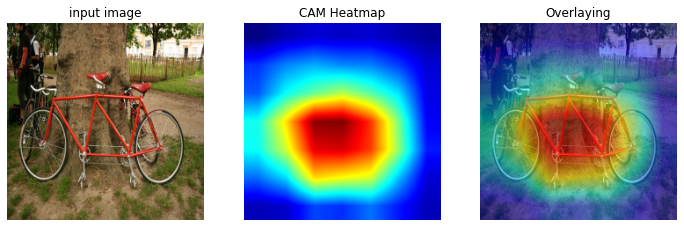

In [12]:
# Resize the input image and the obtained CAM heatmap to 224*224 for overlaying
dim = (224, 224)
# Use applyColorMap to apply a colormap on the resizes heatmap
# [0] to get rid of the first channel
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],dim), cv2.COLORMAP_JET)
# Read input image with opencv
img = cv2.imread(img_path)
resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('The CAM Heatmap for class: {} is generated as following.'.format(classes[target_class]))

# Plot
fig = plt.figure(figsize=(12, 4))
# Plot the input image
ax = fig.add_subplot(1, 3, 1)
# Change the order of the channel from BGR (used by opencv) to standard RGB image for plotting
b,g,r = cv2.split(resized_img)
resized_img = cv2.merge([r,g,b])
imgplot = plt.imshow(resized_img)
plt.axis('off')
ax.set_title('input image')
# Plot the CAM Heatmap
ax = fig.add_subplot(1, 3, 2)
# Change the order of the channel from BGR (used by opencv) to standard RGB image for plotting
b,g,r = cv2.split(heatmap)
heatmap = cv2.merge([r,g,b])
imgplot = plt.imshow(heatmap)
plt.axis('off')
ax.set_title('CAM Heatmap')
# Plot the overlaying
ax = fig.add_subplot(1, 3, 3)
# overlaying heatmap and resized input image.
result = (heatmap * 0.5 + resized_img * 0.5)/255
imgplot = plt.imshow(result)
plt.axis('off')
ax.set_title('Overlaying')